In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image

import json
import time
import math
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

with open('./data/flowers_cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print(cat_to_name['1'])
print(cat_to_name['4'])
print()
classes, c_2_idx = find_classes('./data/flowers/train/')
print(classes)
print(c_2_idx)
print()
cls_2_name = {}
idx_2_fld = {}

print(c_2_idx.keys())
print()
for k in c_2_idx.keys():
    cls = c_2_idx[str(k)]
    cls_2_name[int(cls)] = cat_to_name[str(k)]
    idx_2_fld[int(cls)] = str(k)
print(cls_2_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [3]:

# Note transforms.ToTensor() scales input images
# to 0-1 range

img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    
    transforms.ToTensor()
#    transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                    std=[0.229, 0.224, 0.225] )
    ])

train_data_path = "./data/flowers/train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms)

val_data_path = "./data/flowers/valid/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms)

batch_size=32
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

device = None 

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

print(('load data ---> done!'))

load data ---> done!


In [4]:

import numpy as np
print(train_data[12][0].shape)
# ---- train_data in tuples
n = 1 
labels = [x[n] for x in train_data]
#print(labels)
print(np.unique(labels))          
num_classes = len(np.unique(labels))

print(num_classes)


torch.Size([3, 224, 224])
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
17


torch.Size([3, 224, 224])
tensor([ 5,  3,  0,  6,  5,  0,  3,  3,  1,  2,  7,  7,  3,  2,  2,  5,  3, 12,
         9,  3,  8, 15, 15, 15,  7, 13,  0,  2,  1, 14,  7, 12])


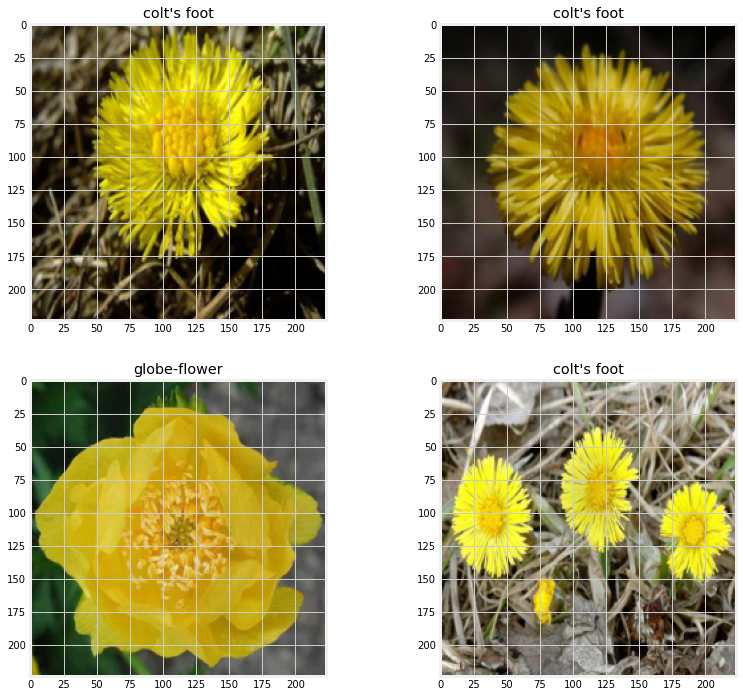

In [5]:
it = iter(train_data_loader)

dt,target = it.next()
print(dt[1].shape)
print(target)

# 显示图片
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
axes[0,0].imshow(dt[1].numpy().transpose(1, 2, 0)) # change (3, 224, 224) => (224, 224, 3)
axes[0,0].title.set_text(cls_2_name[int(target[1].numpy())])
axes[0,1].imshow(dt[6].numpy().transpose(1, 2, 0))
axes[0,1].title.set_text(cls_2_name[int(target[6].numpy())])
axes[1,0].imshow(dt[11].numpy().transpose(1, 2, 0))
axes[1,0].title.set_text(cls_2_name[int(target[11].numpy())])
axes[1,1].imshow(dt[16].numpy().transpose(1, 2, 0))
axes[1,1].title.set_text(cls_2_name[int(target[16].numpy())])
plt.show()

In [10]:
################################
# network InceptionV2
################################

def ConvBNReLU(in_channels,out_channels,kernel_size,stride=1,padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                  stride=stride,padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
    )

def ConvBNReLUFactorization(in_channels,out_channels,kernel_sizes,paddings):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_sizes, 
                  stride=1,padding=paddings),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
        nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_sizes, 
                  stride=1, padding=paddings),
        nn.BatchNorm2d(out_channels),
        nn.ReLU6(inplace=True),
    )

class InceptionV2ModuleA(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, 
                 out_channels3reduce, out_channels3, out_channels4):
        super(InceptionV2ModuleA, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels2reduce, out_channels=out_channels2, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1),
            ConvBNReLU(in_channels=out_channels3reduce, out_channels=out_channels3, kernel_size=3, padding=1),
            ConvBNReLU(in_channels=out_channels3, out_channels=out_channels3, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV2ModuleB(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, 
                 out_channels3reduce, out_channels3, out_channels4):
        super(InceptionV2ModuleB, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2reduce, 
                                    kernel_sizes=[1,3],paddings=[0,1]),
            ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2,
                                    kernel_sizes=[3,1],paddings=[1, 0]),
        )

        self.branch3 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[3, 1], paddings=[1, 0]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[1, 3], paddings=[0, 1]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3reduce,
                                    kernel_sizes=[3, 1], paddings=[1, 0]),
            ConvBNReLUFactorization(in_channels=out_channels3reduce, out_channels=out_channels3,
                                    kernel_sizes=[1, 3], paddings=[0, 1]),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV2ModuleC(nn.Module):
    def __init__(self, in_channels,out_channels1,out_channels2reduce, out_channels2, out_channels3reduce, 
                 out_channels3, out_channels4):
        super(InceptionV2ModuleC, self).__init__()

        self.branch1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels1,kernel_size=1)

        self.branch2_conv1 = ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1)
        self.branch2_conv2a = ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2,
                                                      kernel_sizes=[1,3],paddings=[0,1])
        self.branch2_conv2b = ConvBNReLUFactorization(in_channels=out_channels2reduce, out_channels=out_channels2, 
                                                      kernel_sizes=[3,1],paddings=[1,0])

        self.branch3_conv1 = ConvBNReLU(in_channels=in_channels,out_channels=out_channels3reduce,kernel_size=1)
        self.branch3_conv2 = ConvBNReLU(in_channels=out_channels3reduce, out_channels=out_channels3, 
                                        kernel_size=3,stride=1,padding=1)
        self.branch3_conv3a = ConvBNReLUFactorization(in_channels=out_channels3, out_channels=out_channels3,
                                                      kernel_sizes=[3, 1],paddings=[1, 0])
        self.branch3_conv3b = ConvBNReLUFactorization(in_channels=out_channels3, out_channels=out_channels3,
                                                      kernel_sizes=[1, 3],paddings=[0, 1])

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels4, kernel_size=1),
        )

    def forward(self, x):
        out1 = self.branch1(x)
        x2 = self.branch2_conv1(x)
        out2 = torch.cat([self.branch2_conv2a(x2), self.branch2_conv2b(x2)],dim=1)
        x3 = self.branch3_conv2(self.branch3_conv1(x))
        out3 = torch.cat([self.branch3_conv3a(x3), self.branch3_conv3b(x3)], dim=1)
        out4 = self.branch4(x)
        out = torch.cat([out1, out2, out3, out4], dim=1)
        return out

class InceptionV3ModuleD(nn.Module):
    def __init__(self, in_channels,out_channels1reduce,out_channels1,out_channels2reduce, out_channels2):
        super(InceptionV3ModuleD, self).__init__()

        self.branch1 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels1reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels1reduce, out_channels=out_channels1, kernel_size=3,
                       stride=2,padding=1)
        )

        self.branch2 = nn.Sequential(
            ConvBNReLU(in_channels=in_channels, out_channels=out_channels2reduce, kernel_size=1),
            ConvBNReLU(in_channels=out_channels2reduce, out_channels=out_channels2, kernel_size=3,
                       stride=1, padding=1),
            ConvBNReLU(in_channels=out_channels2, out_channels=out_channels2, kernel_size=3, stride=2,padding=1),
        )

        self.branch3 = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)
        out3 = self.branch3(x)
        out = torch.cat([out1, out2, out3], dim=1)
        return out

class InceptionAux(nn.Module):
    def __init__(self, in_channels,out_channels):
        super(InceptionAux, self).__init__()

        self.auxiliary_avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.auxiliary_conv1 = ConvBNReLU(in_channels=in_channels, out_channels=128, kernel_size=1)
        self.auxiliary_conv2 = nn.Conv2d(in_channels=128, out_channels=768, kernel_size=5,stride=1)
        self.auxiliary_dropout = nn.Dropout(p=0.7)
        self.auxiliary_linear1 = nn.Linear(in_features=768, out_features=out_channels)

    def forward(self, x):
        x = self.auxiliary_conv1(self.auxiliary_avgpool(x))
        x = self.auxiliary_conv2(x)
        x = x.view(x.size(0), -1)
        out = self.auxiliary_linear1(self.auxiliary_dropout(x))
        return out

class InceptionV2(nn.Module):
    def __init__(self, num_classes=1000, stage='train'):
        super(InceptionV2, self).__init__()
        self.stage = stage

        self.block1 = nn.Sequential(
            ConvBNReLU(in_channels=3, out_channels=64, kernel_size=7,stride=2,padding=3),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )

        self.block2 = nn.Sequential(
            ConvBNReLU(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2,padding=1),
        )

        self.block3 = nn.Sequential(
            InceptionV2ModuleA(in_channels=192,out_channels1=64,out_channels2reduce=64, out_channels2=64, 
                               out_channels3reduce=64, out_channels3=96, out_channels4=32),
            InceptionV2ModuleA(in_channels=256, out_channels1=64, out_channels2reduce=64, out_channels2=96,
                               out_channels3reduce=64, out_channels3=96, out_channels4=64),
            InceptionV3ModuleD(in_channels=320, out_channels1reduce=128, out_channels1=160, 
                               out_channels2reduce=64,out_channels2=96),
        )

        self.block4 = nn.Sequential(
            InceptionV2ModuleB(in_channels=576, out_channels1=224, out_channels2reduce=64, 
                               out_channels2=96,out_channels3reduce=96, out_channels3=128, out_channels4=128),
            InceptionV2ModuleB(in_channels=576, out_channels1=192, out_channels2reduce=96, 
                               out_channels2=128,out_channels3reduce=96, out_channels3=128,
                               out_channels4=128),
            InceptionV2ModuleB(in_channels=576, out_channels1=160, out_channels2reduce=128,
                               out_channels2=160,out_channels3reduce=128, out_channels3=128, out_channels4=128),
            InceptionV2ModuleB(in_channels=576, out_channels1=96, out_channels2reduce=128,
                               out_channels2=192,out_channels3reduce=160, out_channels3=160, out_channels4=128),
            InceptionV3ModuleD(in_channels=576, out_channels1reduce=128, out_channels1=192,
                               out_channels2reduce=192,out_channels2=256),
        )

        self.block5 = nn.Sequential(
            InceptionV2ModuleC(in_channels=1024, out_channels1=352, out_channels2reduce=192,
                               out_channels2=160,out_channels3reduce=160, out_channels3=112, out_channels4=128),
            InceptionV2ModuleC(in_channels=1024, out_channels1=352, out_channels2reduce=192, out_channels2=160,
                               out_channels3reduce=192, out_channels3=112, out_channels4=128)
        )

        self.max_pool = nn.MaxPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.5)
        self.linear = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.max_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        out = self.linear(x)
        return out


In [11]:
model = InceptionV2(num_classes=num_classes, stage='train')
#print(model)

input = torch.randn(8,3,224,224)
out = model(input)
print(out.shape)

torch.Size([8, 17])


In [12]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device="cpu"):

    for epoch in range(epochs):
        
        print('---- Training ----')
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        print('---- Validating ----')
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {},  Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(
            epoch + 1, training_loss, valid_loss, num_correct / num_examples))

In [13]:
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training model

In [14]:
# Training model

train(model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,
      val_data_loader, epochs=10, device=device)

---- Training ----
---- Validating ----
Epoch: 1,  Training Loss: 3.34, Validation Loss: 2.83, accuracy = 0.06
---- Training ----
---- Validating ----
Epoch: 2,  Training Loss: 2.84, Validation Loss: 2.58, accuracy = 0.13
---- Training ----
---- Validating ----
Epoch: 3,  Training Loss: 2.42, Validation Loss: 2.31, accuracy = 0.24
---- Training ----
---- Validating ----
Epoch: 4,  Training Loss: 2.11, Validation Loss: 1.84, accuracy = 0.36
---- Training ----
---- Validating ----
Epoch: 5,  Training Loss: 1.90, Validation Loss: 1.79, accuracy = 0.39
---- Training ----
---- Validating ----
Epoch: 6,  Training Loss: 1.70, Validation Loss: 1.81, accuracy = 0.38
---- Training ----
---- Validating ----
Epoch: 7,  Training Loss: 1.38, Validation Loss: 1.43, accuracy = 0.47
---- Training ----
---- Validating ----
Epoch: 8,  Training Loss: 1.27, Validation Loss: 1.48, accuracy = 0.56
---- Training ----
---- Validating ----
Epoch: 9,  Training Loss: 1.07, Validation Loss: 1.20, accuracy = 0.62
-

### Test

In [16]:
test_data_path = "./data"/flowers/test/"
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms)

batch_size=32
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

loss_fn = torch.nn.CrossEntropyLoss()

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0.0

for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    output = model(inputs)
    targets = targets.to(device)
    loss = loss_fn(output,targets) 
    test_loss += loss.data.item() * inputs.size(0)
    correct = torch.eq(torch.max(F.softmax(output), dim=1)[1], targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.2f}, accuracy = {:.2f}'.format(test_loss, num_correct / num_examples))

Test Loss: 1.27, accuracy = 0.60


tensor([ 5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11, 11])
tensor([ 5,  5,  5,  6,  6,  6, 15, 12,  1,  7,  8,  8,  8, 11,  2, 10,  8,  8,
         8,  9,  9,  2,  9,  9, 10, 16, 11, 11, 10, 16,  2,  0])


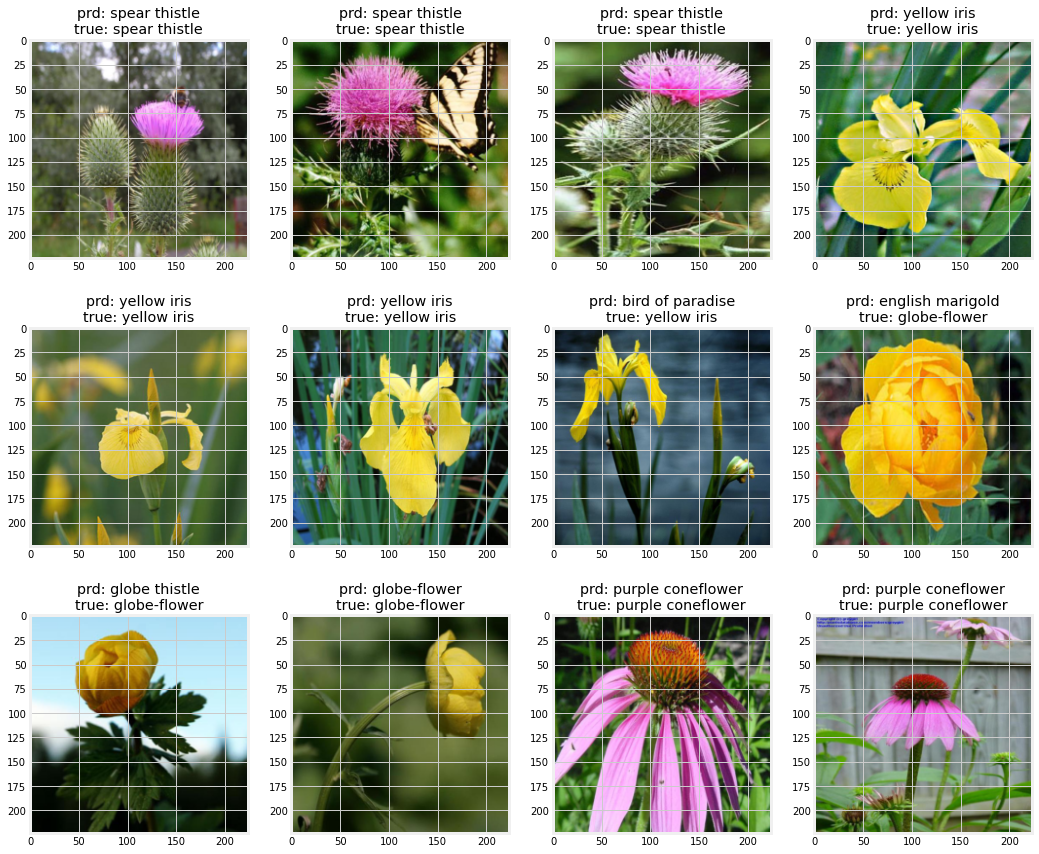

In [17]:
it = iter(test_loader)
it.next()
dt, labs = it.next()
dt = dt.to(device)
output = model(dt)
prd_labs = torch.max(F.softmax(output), dim=1)[1].view(-1)
print(labs)
print(prd_labs)

plt.figure(figsize=(16,15))
k = 0
for i in range(3):
    for j in range(4):
        ax = plt.subplot2grid((3,4), (i,j))
        #print(dt[k].numpy().transpose((1, 2, 0)).shape)
        tlt = 'prd: ' + cls_2_name[int(prd_labs[k].numpy())] + '\ntrue: ' + cls_2_name[int(labs[k].numpy())]
        ax.imshow(dt[k].numpy().transpose((1, 2, 0)))
        ax.title.set_text(tlt)
        #ax.scatter(range(20),range(20)+np.random.randint(-5,5,20))
        k = k + 1
plt.show()